# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#load-and-normalize-cifar10)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
'''
Define transforms
pixel color normalize stats per ImageNet dataset specification, same values for train and test. 
'''
pixel_mean = [0.5, 0.5, 0.5]
pixel_std = [0.5, 0.5, 0.5]
img_crop_size = 32
img_side_px = 32
batch_size=100

'''
We wanted to create random transforms for the training set
and then use a different transform for both the validation and training sets.
Doing so turned out to be difficult to do if we wanted to use the provide CIFAR loader, 
so we use the same transform appropriate for all three loaders 
and we do not do random processing on the training.
'''
shared_transforms = transforms.Compose([
    transforms.Resize(img_side_px),
    transforms.CenterCrop(img_crop_size),
    transforms.ToTensor(),
    transforms.Normalize(pixel_mean, pixel_std)
])

train_transforms = shared_transforms
test_transforms = shared_transforms

# commented out here is an example of what we might have explored for randomizing the input
# if we had not prioritized splitting the training dat into a validation set.
# rotation=30
# transforms.Compose([
#     transforms.RandomRotation(rotation),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(pixel_mean, pixel_std)
# ])

''' 
Create training set and define training dataloader
'''
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

''' 
split out some validation data from the training set
'''
validation_size = 0.2
num_samples = len(cifar_trainset)
num_validation = int(validation_size * num_samples)
num_train = num_samples - num_validation
trainset, validationset = torch.utils.data.random_split(cifar_trainset, [num_train, num_validation])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])

        fig, axarr = plt.subplots(1, 2)

        image_normalized = images[i].numpy()
        axarr[0].imshow(image_normalized.T)
        axarr[0].set_title(f"Normalized {classes[labels[i]]}")  

        # unnormalize from pytorch.org cifar10 docs
        image_unnormal = images[i] / 2 + 0.5
        image_unnormal = image_unnormal.numpy()
        axarr[1].imshow(image_unnormal.T)
        axarr[1].set_title(f"Regular {classes[labels[i]]}")    

        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.85882354].


deer


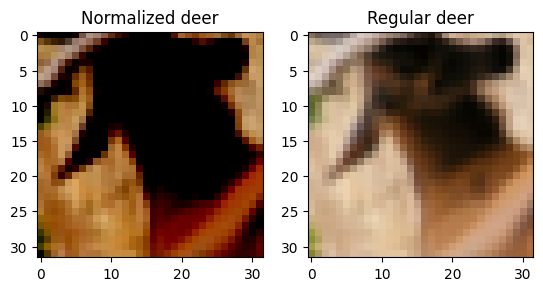

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6392157..1.0].


bird


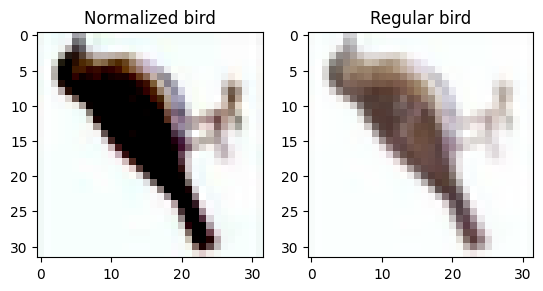

ship


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..0.9764706].


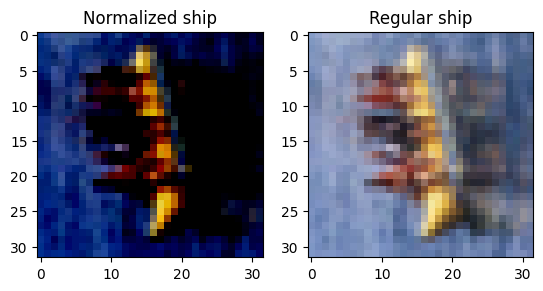

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


plane


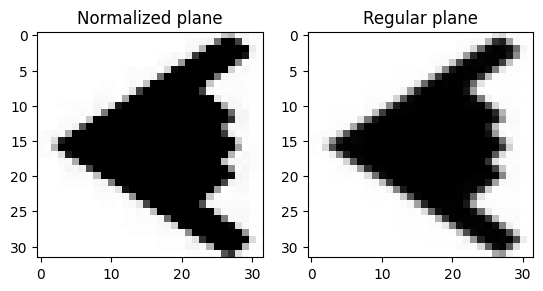

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].


frog


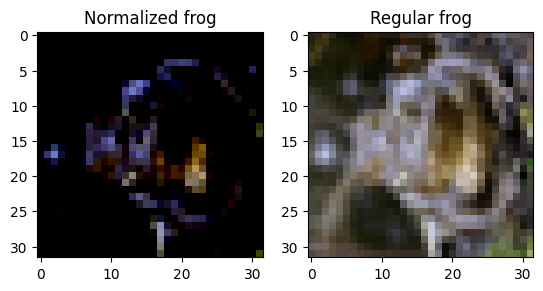

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


cat


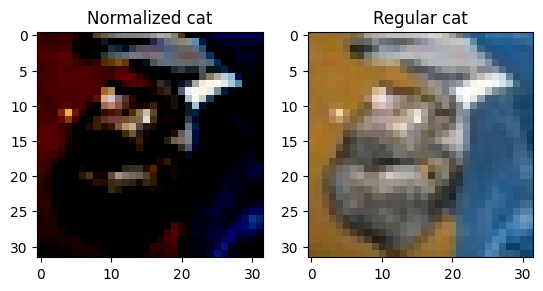

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].


ship


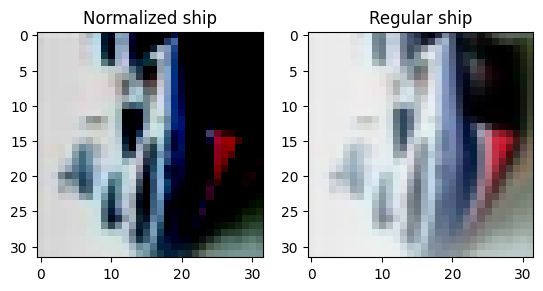

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].


ship


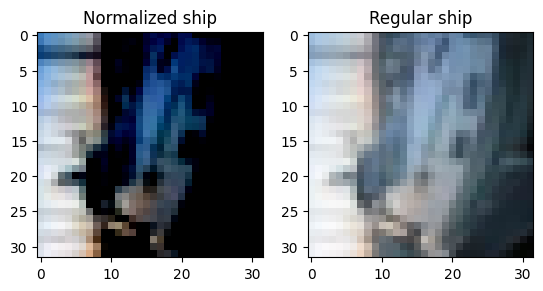

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].


plane


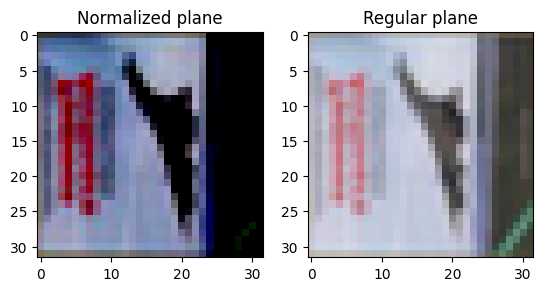

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].


frog


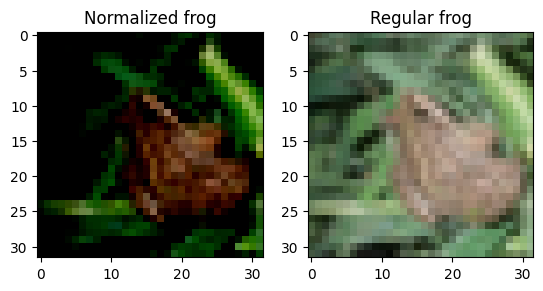

In [4]:
# Explore data
show5(trainloader) # images are shuffled and different each run
show5(testloader)  # images are same for each run

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
''' 
This InceptionModule class was given to me by Udacity GPT
I watched the videos from the Udacity Neural Network and asked U-GPT for more information about Inception
and this class was the result.

The GPT provided model on its own gave poor results, I neglected to note the exact results but was maybe around ~40% unmodified,
which was generally worse than what I was exploring without it.

I had been tinkering with two other adhoc models I had come up with prior to exploring Inception.
1. My simpler "bad" model had been getting around 40% prior to inception, and improved to 62% after.
2. My more complicated "better" model had been getting around 52% and actually got worse after inception, closer to ~40%.

I continued to use Inception and to make improvements to my simpler "bad" model because it worked so well with Inception as the first step.
'''
class InceptionModule(nn.Module):
    def __init__(self, in_channels):
        super(InceptionModule, self).__init__()
        
        # 1x1 convolution
        self.conv1x1 = nn.Conv2d(in_channels, 64, kernel_size=1)
        
        # 3x3 convolution
        self.conv3x3 = nn.Conv2d(in_channels, 128, kernel_size=3, padding=1)
        
        # 5x5 convolution
        self.conv5x5 = nn.Conv2d(in_channels, 32, kernel_size=5, padding=2)
        
        # 3x3 max pooling followed by 1x1 convolution
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.conv_after_pool = nn.Conv2d(in_channels, 32, kernel_size=1)
        
    def forward(self, x):
        out1 = F.relu(self.conv1x1(x))
        out2 = F.relu(self.conv3x3(x))
        out3 = F.relu(self.conv5x5(x))
        out4 = F.relu(self.conv_after_pool(self.maxpool(x)))
        
        # Concatenate along the channel dimension
        outputs = torch.cat([out1, out2, out3, out4], dim=1)
        return outputs


In [6]:
""" MyModel 
This model leverages the InceptionModel output as the first step.

We apply 2 convolutional layers on the inception output.
In both cases we apply a max pool in an attempt to emphasize the important
feature for the model to notice.

We use dropout only once, applied to the output of the first convolutional layer.
We found this one positioning of dropout to provide a slight improvement to the model
per our observation of validation loss remaining close to training loss as the model
accuracy increasted by a couple percentag points.

The use of additional dropouts, or moving the single dropout
to another position generally made the performance worse
or required more epochs to achieve similar results.

We apply two fully connected layers after the convolutional layers.
The first of these applies relu and provides a last opportunity for the network to learn something.
The last fully connected layer is used primarily to form the results into the expected class output dimensions.
"""
class MyModel(nn.Module):
    def __init__(self, output_count=10):
        super(MyModel, self).__init__()

        self.output_count = output_count

        # Inception
        self.inception = InceptionModule(in_channels=3)

        # 1
        self.conv1 = nn.Conv2d(256, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(4, 4)

        # 2
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(4, 4)

        # 1
        self.fc1 = nn.Linear(64, 1024)

        # final
        self.fc_out = nn.Linear(1024, output_count)

    def forward(self, x):

        # inception
        x = self.inception(x)

        # 1
        x = self.conv1(x)
        x = self.pool1(x)

        # dropout
        x = F.dropout(x, 0.2)

        # 2
        x = self.conv2(x)
        x = self.pool2(x)

        # flatten
        x = torch.flatten(x, 1)

        # 1
        x = self.fc1(x)
        x = F.relu(x)

        # final
        x = self.fc_out(x)

        # classifier probabilities
        x = F.log_softmax(x, dim=1)
        return x



Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

We explored using a few common loss functions and optimizers.
* optimizers: SGD and Adam
* loss: CrossEntropyLoss and NLLoss

Swapping out any of these choices also requires changing hyperparameters, particularly `learning rate`,
but also influences the number of epochs and dropout choices.

In the end we found that the combination of `Adam` and `NLLLoss` resulted in the simplest selection of
hyperparameters for achieving acceptable results.

In [7]:
# input count is the size of an image
input_count = img_side_px * img_side_px
model = MyModel(output_count=len(classes))

criterion = nn.NLLLoss()

default_learn_rate = 0.001
optimizer = optim.Adam(params=model.parameters(), lr=default_learn_rate)


Define a helper function to help track and record accuracy and loss.

In [8]:
# evaluate the model on the specified dataloader using the crierion

''' check_accuracy
    model: pythorch model extends nn.Module
    criterion: pytorch loss module
    dataloader: data source
    device: use the specified processing device as returned by torch.device(...)

    Return loss, accuracy
'''
def check_accuracy(model, criterion, dataloader, device=None):
    loss = 0
    accuracy = 0

    if not device:
        device_name = "cuda" if torch.cuda.is_available() else "cpu"
        device = torch.device(device_name)
    model.to(device)

    # turn off training
    model.eval()

    # disable gradient tracking during evaluation
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            # run the model on a batch
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            # capture statistics
            loss += batch_loss.item()
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
    # turn training mode back on
    model.train()

    loss = loss/len(dataloader)
    accuracy = accuracy/len(dataloader)

    return loss, accuracy


''' print_metrics_record
    record: dictionary of metrics properties
            epoch: epoch index of the record
            batch: batch index of the record
            validation_accuracy: calculated validation accuracy between 0 and 1
            validation_loss: calulated loss for the batch
            training_loss: calculated loss for the batch
            type: type of record indicates the kind of printout to be used
'''
def print_metrics_record(record):
    type = record['type']
    if type == 'eval':
        print((
            f"{type}: id={record['epoch']}-{record['batch']}  " 
            f"validation_accuracy={record['validation_accuracy']:.2f}  " 
            f"validation_loss={record['validation_loss']:.2f}  "
            f"training_loss={record['training_loss']:.2f}  "
        ))
    elif type == 'batch':
        print(f"{type}")
    elif type == 'epoch':
        print(f"{type}")



## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
epochs = 8
# how many batches are procesed before we print a summary
# each batch represents training on "batch_size" images
print_every = 100

device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
model.to(device)
print(f"Training device: {device_name}")

# we keep track of training stats as records in a metrics array 
# so we cah show summaries after training
metrics = []
def produce_metrics_record(type, epoch):
    return {
        'type': type,
        'running_loss': 0, 
        'epoch': epoch
    }

learn_rate = default_learn_rate
for epoch in range(epochs):
    running_loss = 0
    epoch_record = produce_metrics_record(type='epoch', epoch=epoch)
    loader = trainloader
    print(f"epoch-{epoch}")
    for batch_count, (inputs, labels) in enumerate(loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        
        batch_record = produce_metrics_record(type='batch', epoch=epoch)
        batch_record['batch'] = batch_count
        
        optimizer.zero_grad()

        # capture probabilities in forward step
        logps = model.forward(inputs)
        loss = criterion(logps, labels)

        loss.backward()

        # update parameters with lessons learned
        optimizer.step()

        # track loss over many batches
        running_loss += loss.item()
        batch_record['running_loss'] = running_loss
        metrics.append(batch_record)

        # every few batches evaluate performance and print metrics
        if batch_count > 0 and batch_count % print_every == 0:
            eval_record = produce_metrics_record(type='eval', epoch=epoch)
            eval_record['batch'] = batch_count
            eval_record['training_loss'] = running_loss / (batch_count + 1)
            validation_loss, validation_accuracy = check_accuracy(model=model, criterion=criterion, dataloader=validationloader, device=device)
            eval_record['validation_loss'] = validation_loss
            eval_record['validation_accuracy'] = validation_accuracy
            metrics.append(eval_record)
            
            print_metrics_record(eval_record)
            
            
    metrics.append(epoch_record)

Training device: cuda
epoch-0
eval: id=0-100  validation_accuracy=0.40  validation_loss=1.65  training_loss=1.90  
eval: id=0-200  validation_accuracy=0.45  validation_loss=1.49  training_loss=1.75  
eval: id=0-300  validation_accuracy=0.49  validation_loss=1.38  training_loss=1.65  
epoch-1
eval: id=1-100  validation_accuracy=0.52  validation_loss=1.34  training_loss=1.30  
eval: id=1-200  validation_accuracy=0.55  validation_loss=1.25  training_loss=1.28  
eval: id=1-300  validation_accuracy=0.56  validation_loss=1.21  training_loss=1.26  
epoch-2
eval: id=2-100  validation_accuracy=0.59  validation_loss=1.16  training_loss=1.13  
eval: id=2-200  validation_accuracy=0.59  validation_loss=1.14  training_loss=1.12  
eval: id=2-300  validation_accuracy=0.60  validation_loss=1.13  training_loss=1.11  
epoch-3
eval: id=3-100  validation_accuracy=0.61  validation_loss=1.08  training_loss=1.03  
eval: id=3-200  validation_accuracy=0.63  validation_loss=1.04  training_loss=1.03  
eval: id=3-

Plot the training loss (and validation loss/accuracy, if recorded).

We used this graph after training completed as a key component to evaluating each model.

We initially limited the number of epochs such that training would be considered done whenever
training loss was lower than validation loss for many iterations.

Later we modified that concept to allow training to continue even when training loss was lower
than validation loss, as long as we also saw improvements in validation loss, even if the improvements
were smaller.

The Graph below shows we 

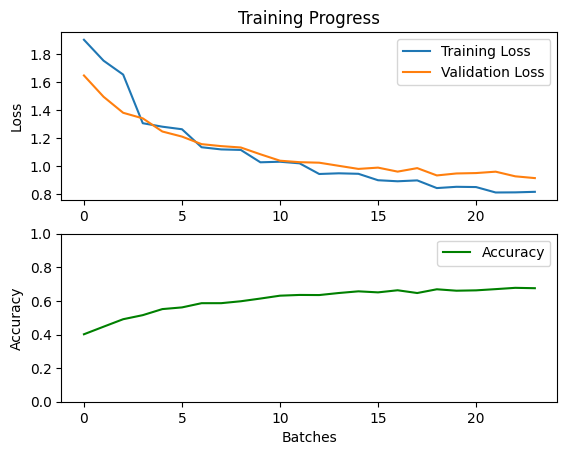

In [10]:
''' plot_loss
Plots graphs for validation and training loss, as well as validation accuracy.
Parameters:
    metrics: this is a dictionary of data recorded during training.
'''
def plot_loss(metrics):
    train_loss = [m['training_loss'] for m in metrics if m['type'] == 'eval']
    val_loss = [m['validation_loss'] for m in metrics if m['type'] == 'eval']
    accuracy = [m['validation_accuracy'] for m in metrics if m['type'] == 'eval']
    # Creating the figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1)

    # Plotting the training loss and validation loss on the primary y-axis
    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_ylabel('Loss')

    # Plotting the accuracy on the secondary y-axis
    ax2.plot(accuracy, label='Accuracy', color='green')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim([0, 1])

    # Adding labels and title to the plot
    ax2.set_xlabel('Batches')
    ax1.set_title('Training Progress')

    # Adding a legend to the plot
    ax1.legend()
    ax2.legend()

    # Displaying the plot
    plt.show()

    # Clearing the subplots
    ax1.clear()
    ax2.clear()


plot_loss(metrics)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
loss, accuracy = check_accuracy(model=model, criterion=criterion, dataloader=testloader)

print(f"accuracy={accuracy:.2f}  loss={loss:.2f}")

accuracy=0.68  loss=0.92


## Saving your model
Using `torch.save`, save your model for future loading.

In [12]:
''' save_model
'''
def save_model(model, filename):
    checkpoint = {
        'state_dict': model.state_dict(),
        'metadata': {
            'criterion': 'NLLLoss',
            'optimizer': 'Adam',
            'optimizer_state': optimizer.state_dict(),
            'learnrate': learn_rate,
            'epochs': epochs,
            'batch_size': batch_size,
            'output_count': model.output_count,
        }
    }
    torch.save(checkpoint, filename)
    print(f"Model saved to {filename}")

save_model(model, 'checkpoint.pth')

Model saved to checkpoint.pth


Now we verify we can load the model and get the expected performance using the restored model.

Predictions on the restored model and on the original model can be slightly different from previous results due to random variations in the model but thes should always be within about 0.01 of previous results for accuracy and loss.

In other words, although the data below may be different based on the run that was saved, as long as the numbers are very close e consider our restore of the model to be a success.

In [13]:
''' load_model
'''
def load_model(filename):
    checkpoint = torch.load(filename)
    output_count = checkpoint['metadata']['output_count']
    loaded_model = MyModel(output_count=output_count)
    loaded_model.load_state_dict(checkpoint['state_dict'])

    return loaded_model

restored_model = load_model('checkpoint.pth')


loss, accuracy = check_accuracy(model=restored_model, criterion=criterion, dataloader=testloader)

print(f"accuracy={accuracy:.2f}  loss={loss:.2f}")

accuracy=0.68  loss=0.92


Below we use the restored model to predict the same five images we explored earlier from the test set.

In [14]:
''' print_predictions
Print the list of predictions in a table.
Parameters:
    predictions: list tuples containing (index, name, probability)
'''
def print_predictions(predictions, title=None):
    if title:
        print(f"{title}\n")
    print(f"{'Idx':>4} {'Name':<30} {'Probability'}")
    for category, name, probability in predictions:
        print(f"{category:>4} {name:<30} {probability*100:.3}%")
    print()


''' predict
Predict the class (or classes) of an image using a trained deep learning model.
    Return a ziped list of the topk picks: (category_index, category_name, probability)
'''
def predict(image, model, category_names, device_name=None, topk=3):
    if not device_name:
        device_name = "cuda" if torch.cuda.is_available() else "cpu"
    
    device = torch.device(device_name)

    image = image.to(device)
    model.eval()
    model.to(device)
    with torch.no_grad():
        logps = model(image.unsqueeze(0))
    ps = torch.exp(logps)
    model.train()

    top_values, top_indices = torch.topk(ps, k=topk)
    top_names = [category_names[idx] for idx in top_indices[0].tolist()]

    return zip(top_indices[0].tolist(), top_names, top_values[0].tolist())


''' predict5 
Select the first 5 images from the image loader and predict their category.
'''
def predict5(img_loader):
    dataiter = iter(img_loader)
    batch = next(dataiter)
    real_labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(f"Actual: {real_labels[i]} {classes[real_labels[i]]}")
        image = images[i]
        prediction = predict(image, restored_model, classes)
        print_predictions(prediction)

predict5(testloader)


Actual: 3 cat
 Idx Name                           Probability
   3 cat                            52.0%
   5 dog                            21.1%
   8 ship                           15.0%

Actual: 8 ship
 Idx Name                           Probability
   1 car                            79.4%
   8 ship                           17.8%
   0 plane                          2.05%

Actual: 8 ship
 Idx Name                           Probability
   8 ship                           79.7%
   1 car                            14.5%
   9 truck                          3.17%

Actual: 0 plane
 Idx Name                           Probability
   8 ship                           47.4%
   0 plane                          37.7%
   9 truck                          4.94%

Actual: 6 frog
 Idx Name                           Probability
   6 frog                           96.9%
   2 bird                           1.79%
   3 cat                            0.845%



The output table of predictions above confirms that our model results are reasonably well aligned with the sanity check.

The table above is from a selected prediction test show how most images were predicted correctly.
* Notice that in the above example the `Actual: 0 plane` image was predicted to be `8 ship` instead of `plain`.

Reliability Observations:
* We observed that running that cell again to get predictions on the same images from the unshuffled testloader would produce different probabilities.
* We think this difference is a result of randomness in how the model evaluates the data.
* After most training sequences this table shows correct results for 4/5 samples, but we were surprised that the results were not identical in repeated tests.

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

In considering whether or not to recommend the purchase of Detectocorp's product we explored the process of designing and training a model with our own code and also read several research papers describing the current state of the art in machine learning and neural networks.

We found that even as a beginner with limited time allocated to this task we were able to achieve 67-69% accuracy on the CIFAR-10 test dataset. Squeezing another 2% out of our model would be challenging and time consuming, however in exploring this task we also constrained ourselves from doing a significant amount of searching for existing opensource code projects where we could likely find much better performing models than what we constructed for this experiment.

The state of the art models today can achieve far better performance, approaching 99% on the CIFAR-10 dataset and there are many professional and amature researchers and hobbiests publishing ideas and models on the internet that are licensed in such a way that we could use those as a starting point.

The one caveat to moving forward with a recommendation is to comment that the CIFAR-10 dataset is only a bench mark and is fairly specific to the data classes it identifies for its sample data. Before discarding Detectocorps solution based on my recommendaion here we should give Dectocorp one more opportunity to explain to us whether they have experimental evidence to support that Detectocorp's model would perform especially well for the purpose of rapid object identification in a video stream similar to what we expect to recieve in our self driving car application.

In the absense of new evidence from Detectocorp, my recommendation is as follows.

1. Do not purchase Detectocorps aproduct, the evidence provided so far suggests that we can do much better on our own.

2. Developing the model in house is not cheap either, but as an investment in our future as a self-driving car startup we will need to have full control over the training and tuning of the model and owning our work outright is a good idea for the company. Even if we were to seek another vendor beyond Detectocorps, we would need to hire a small team of neural network and imaging processing experts in order to effectivly integrate the model with the rest of our architecture.

In summary, I recommend we develop the solution in house because I believe the will be the most effective way for us to build inhouse skillsets and be a foundational part our intellectual property as we continue to evolve the company.